# Using qulacs

To make use of the quantum simulators, we need to use qulacs, more especifically, qulacs-mpi. Here we try to transform the hhl qiskit circuit to a qulacs circuit. We can also explore the possibility of adding an atribute to the HHL class, where we store the qulacs circuit.

In [1]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from qiskit.qasm3 import dumps
from numpy_matrix import NumPyMatrix
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from itertools import product
from hhl_functions import *
import multiprocessing as mp
import time
from qulacs import QuantumCircuit as QulacsCircuit, Observable, QuantumState
from qulacs.gate import DenseMatrix

In [2]:
def qiskit_to_qulacs(qiskit_circuit: QuantumCircuit):

    qiskit_qubits = qiskit_circuit.qubits
    qubit_index_map = {q: i for i, q in enumerate(qiskit_qubits)}

    n_qubits = len(qiskit_qubits)
    qulacs_circuit = QulacsCircuit(n_qubits)
    gates={'cx':0,'x':0,'h':0,'r':0,'rz':0,'rx':0,'ry':0,'u':0,'u2':0,'u1':0,'otro':0}
    
    for instruction in qiskit_circuit.data:
        gate, qargs, _ = instruction        
        qubit_indices = [qubit_index_map[q] for q in qargs]
        if not gate.params or np.any(gate.params):
            if gate.name == 'cx':
                qulacs_circuit.add_CNOT_gate(qubit_indices[0], qubit_indices[1])
                gates['cx']+=1
            elif gate.name == 'x':
                qulacs_circuit.add_X_gate(qubit_indices[0])
                gates['x']+=1
            elif gate.name == 'h':
                qulacs_circuit.add_H_gate(qubit_indices[0])
                gates['h']+=1
            elif gate.name == 'r':
                theta,phi = gate.params
                R_gate = np.array([
                    [np.cos(theta / 2), -1j * np.exp(-1j * phi) * np.sin(theta / 2)],
                    [-1j * np.exp(1j * phi) * np.sin(theta / 2), np.cos(theta / 2)]
                ])
                qulacs_gate = DenseMatrix(qubit_indices[0], R_gate)
                qulacs_circuit.add_gate(qulacs_gate)
                gates['r']+=1
            elif gate.name == 'rz':
                qulacs_circuit.add_RZ_gate(qubit_indices[0], gate.params[0])
                gates['rz']+=1
            elif gate.name == 'ry':
                theta = gate.params[0]
                RY_gate = np.array([
                    [np.cos(theta / 2), -np.sin(theta / 2)],
                    [np.sin(theta / 2),  np.cos(theta / 2)]
                ])
                qulacs_gate = DenseMatrix(qubit_indices[0], RY_gate)
                qulacs_circuit.add_gate(qulacs_gate)
                gates['ry']+=1
            elif gate.name == 'rx':
                qulacs_circuit.add_RX_gate(qubit_indices[0], gate.params[0])
                gates['rx']+=1
            elif gate.name == 'u3' or gate.name == 'u':
                theta, phi, lam = gate.params
                qulacs_circuit.add_U3_gate(qubit_indices[0], theta, phi, lam)
                gates['u']+=1
            elif gate.name == 'u2':
                phi, lam = gate.params
                qulacs_circuit.add_U2_gate(qubit_indices[0], phi, lam)
                gates['u2']+=1
            elif gate.name == 'u1':
                lam = gate.params[0]
                qulacs_circuit.add_U1_gate(qubit_indices[0], lam)
                gates['u1']+=1
            elif gate.name == 'barrier':
                gates['otro']+=1
                continue
            else:
                print(f"Gate {gate.name} is not supported in this script yet.")
    
    return qulacs_circuit

qc = QuantumCircuit(2)

qc.x(0)
qc.h(1)
qc.cx(1,0)

st = Statevector(qc).data.real
qulc = qiskit_to_qulacs(qc)

n_qubits = qc.num_qubits
state = QuantumState(n_qubits)
qulc.update_quantum_state(state)
state_vector = state.get_vector().real
print(st)
print(state_vector)
print((st-state_vector))

[0.         0.70710678 0.70710678 0.        ]
[0.         0.70710678 0.70710678 0.        ]
[0. 0. 0. 0.]


In [3]:
nb = 4
NB = 2**nb
vector = np.array([1]*NB)
matrix = tridiag_matrix(2,-1,NB)
hhl = HHL(matrix,vector)

hhl.qc = prepare_circ(hhl.qc)
hhl_qul = qiskit_to_qulacs(hhl.qc)
n_qubits = hhl.qc.num_qubits

start = time.time()
st = Statevector(hhl.qc).data.real
end = time.time()
# print(np.round(st,5))
print("Time with Qiskit: ",end-start)

start = time.time()
state = QuantumState(n_qubits)
hhl_qul.update_quantum_state(state)
state_vector = state.get_vector().real
end= time.time()

# print(np.round(state_vector,5))
print("Time with Qulacs: ",end-start)
# print(np.round(st-state_vector,5))

In [ ]:
print('Puertas del circuito de dimension 16:',gates_16)
print('Puertas del circuito de dimension 8:',gates_8)

Puertas del circuito de dimension 16: {'cx': 253196, 'x': 0, 'h': 0, 'r': 0, 'rz': 0, 'rx': 0, 'ry': 0, 'u': 408097, 'u2': 0, 'u1': 0, 'otro': 3}
Puertas del circuito de dimension 8: {'cx': 23812, 'x': 0, 'h': 0, 'r': 0, 'rz': 0, 'rx': 0, 'ry': 0, 'u': 39001, 'u2': 0, 'u1': 0, 'otro': 3}


In [ ]:
print(max(st-state_vector))

1.4845416922455168e-14


In [ ]:
num = 2**(n_qubits-1)
sol = np.linalg.solve(matrix,vector)
print("Qiskit:",st[num:num+2**nb])
print("Qulacs:",state_vector[num:num+2**nb])
print("Real:",sol/np.linalg.norm(sol))

Qiskit: [0.06809166 0.12763513 0.17868067 0.22122135 0.25532651 0.28093765
 0.2980614  0.30663171 0.30663171 0.2980614  0.28093765 0.25532651
 0.22122135 0.17868067 0.12763513 0.06809166]
Qulacs: [0.06809166 0.12763513 0.17868067 0.22122135 0.25532651 0.28093765
 0.2980614  0.30663171 0.30663171 0.2980614  0.28093765 0.25532651
 0.22122135 0.17868067 0.12763513 0.06809166]
Real: [0.07354631 0.13789934 0.19305907 0.23902552 0.27579867 0.30337854
 0.32176512 0.33095841 0.33095841 0.32176512 0.30337854 0.27579867
 0.23902552 0.19305907 0.13789934 0.07354631]


As we can see, the difference in time is notable, mostly when we increase the size of the problem. We can graph this speedup.

In [3]:
time_qisk=[]
time_qul=[]
for nb in range(1,5):
    print('Execution with size:',nb)
    NB = 2**nb
    vector = np.array([1]*NB)
    matrix = tridiag_matrix(2,-1,NB)
    hhl = HHL(matrix,vector)

    hhl.qc = prepare_circ(hhl.qc)
    hhl_qul = qiskit_to_qulacs(hhl.qc)
    n_qubits = hhl.qc.num_qubits
    tmp = []
    for _ in range(5):
        start = time.time()
        st = Statevector(hhl.qc).data.real
        end = time.time()
        tmp.append(end-start)
    time_qisk.append(np.mean(tmp))

    tmp=[]
    for _ in range(5):
        start = time.time()
        state = QuantumState(n_qubits)
        hhl_qul.update_quantum_state(state)
        state_vector = state.get_vector().real
        end= time.time()
        tmp.append(end-start)
    time_qul.append(np.mean(tmp))

Execution with size: 1
Execution with size: 2
Execution with size: 3
Execution with size: 4


In [ ]:
print("Time in Qulacs:",time_qul)
print('Time in Qiskit:',time_qisk)

Time in Qulacs: [0.0, 0.00030069351196289064, 0.05919013023376465, 2.529312562942505]
Time in Qiskit: [0.0023040771484375, 0.05168094635009766, 2.044075345993042, 37.16986632347107]


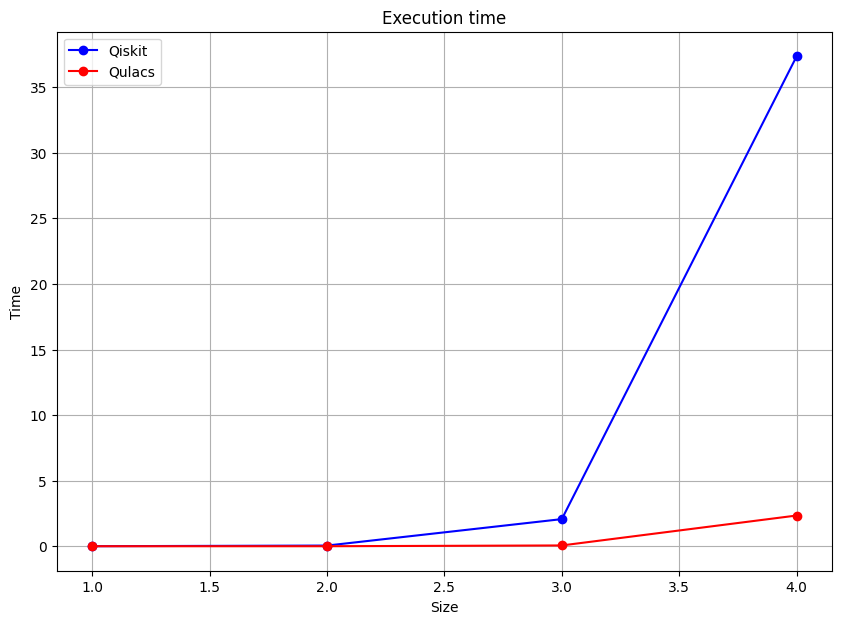

In [4]:
import matplotlib.pyplot as plt

x = np.arange(1,5,1)
plt.figure(figsize=(10, 7))

plt.plot(x, time_qisk, marker='o', linestyle='-', color='blue')
plt.plot(x, time_qul, marker='o', linestyle='-', color='red')
plt.xlabel('Size')
plt.ylabel('Time')
plt.title('Execution time')
plt.legend(['Qiskit','Qulacs'])
plt.grid(True)
plt.show()

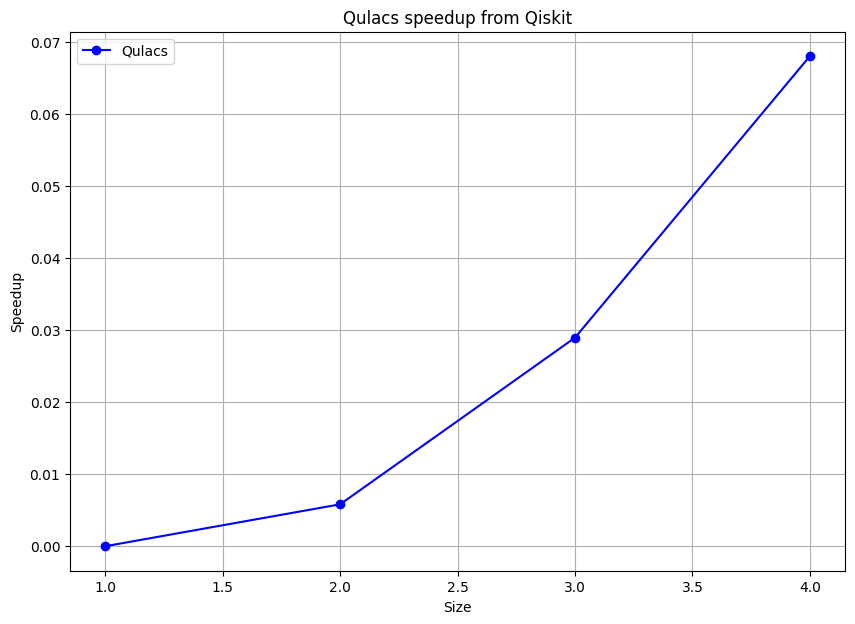

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1,5,1)
data = np.array(time_qul)/np.array(time_qisk)
plt.figure(figsize=(10, 7))

plt.plot(x, data, marker='o', linestyle='-', color='blue')
plt.xlabel('Size')
plt.ylabel('Speedup')
plt.title('Qulacs speedup from Qiskit')
plt.legend(['Qulacs','Qiskit'])
plt.grid(True)
plt.show()

<span style="font-size:1.5em;"><b>However</B></span>, and this is important, if we want to have a fair competition, we must include into the time for qulacs the time it takes to transform the circuit into qulacs. We can also do this

In [ ]:
time_qisk=[]
time_qul=[]
overhead = []
for nb in range(1,5):
    print('Execution with size:',nb)
    NB = 2**nb
    vector = np.array([1]*NB)
    matrix = tridiag_matrix(2,-1,NB)
    hhl = HHL(matrix,vector)
    start = time.time()
    hhl.qc = prepare_circ(hhl.qc)
    hhl_qul = qiskit_to_qulacs(hhl.qc)
    end = time.time()
    prep = end - start
    overhead.append(prep)
    n_qubits = hhl.qc.num_qubits
    tmp = []
    for _ in range(5):
        start = time.time()
        st = Statevector(hhl.qc).data.real
        end = time.time()
        tmp.append(end-start)
    time_qisk.append(np.mean(tmp))

    tmp=[]
    for _ in range(5):
        start = time.time()
        state = QuantumState(n_qubits)
        hhl_qul.update_quantum_state(state)
        state_vector = state.get_vector().real
        end= time.time()
        tmp.append(end-start+prep)
    time_qul.append(np.mean(tmp))

Execution with size: 1
Execution with size: 2
Execution with size: 3
Execution with size: 4


In [ ]:
print("Time in Qulacs:",time_qul)
print('Time in Qiskit:',time_qisk)

Time in Qulacs: [0.11649274826049805, 0.15067873001098633, 4.507387685775757, 56.643358373641966]
Time in Qiskit: [0.0021029949188232423, 0.05263419151306152, 2.0233702659606934, 36.919367122650144]


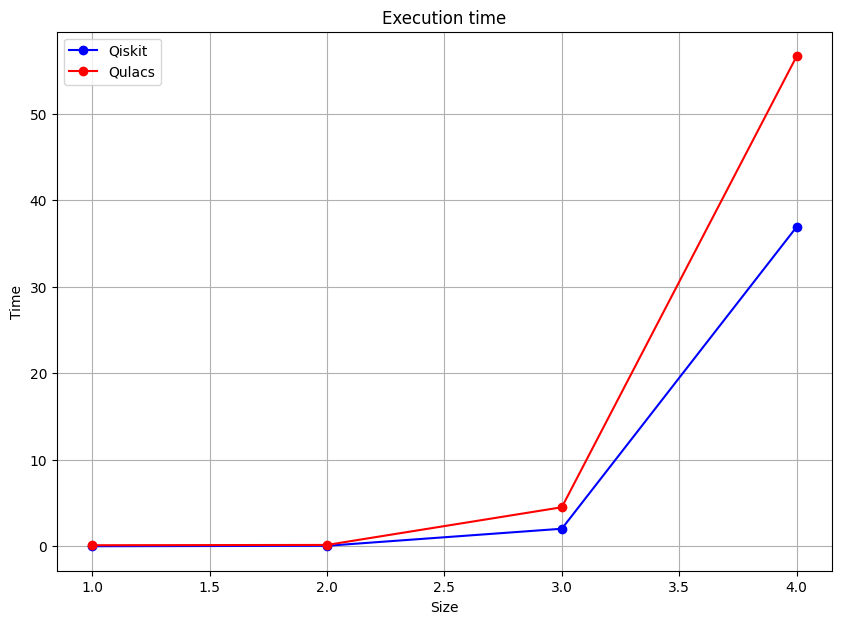

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1,5,1)
plt.figure(figsize=(10, 7))

plt.plot(x, time_qisk, marker='o', linestyle='-', color='blue')
plt.plot(x, time_qul, marker='o', linestyle='-', color='red')
plt.xlabel('Size')
plt.ylabel('Time')
plt.title('Execution time')
plt.legend(['Qiskit','Qulacs'])
plt.grid(True)
plt.show()

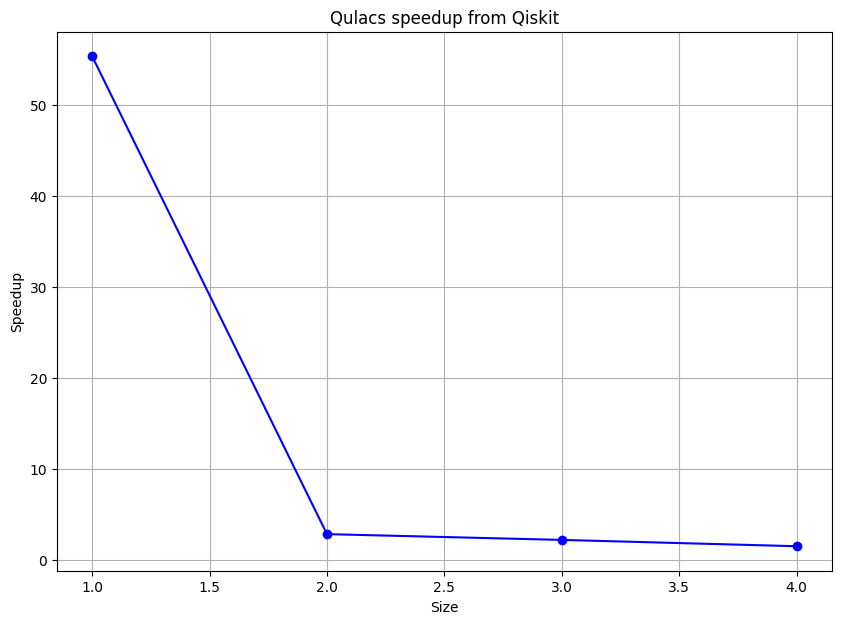

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1,5,1)
data = np.array(time_qul)/np.array(time_qisk)
plt.figure(figsize=(10, 7))

plt.plot(x, data, marker='o', linestyle='-', color='blue')
plt.xlabel('Size')
plt.ylabel('Speedup')
plt.title('Qulacs speedup from Qiskit')
plt.grid(True)
plt.show()

As we can see, the time needed to transform a circuit to qulacs isn't worth the time reduction. The overhead is too big. Bigger than any qiskit execution. However, we can do this test in order to test its efficiency in a quantum hpc emulator and to know the limits that we can achieve if we had directly built the circuit in Qulacs. We can transport this study into Qmio and execute it in the ARM processors.

---

No we can't. We need to use **exclusively** qulacs. To do this, we're going to use QASM. The first cell contains the needed code to dump a Qiskit circuit into a QASM file.

In [6]:
nb = 2
NB = 2**nb
vector = np.array([1]*NB)
matrix = tridiag_matrix(2,-1,NB)
hhl = HHL(matrix,vector)
hhl.qc = prepare_circ(hhl.qc)
qasm = dumps(hhl.qc)
with open('qasm_4.qasm','a+') as file:
    file.write(qasm)

In [11]:
import re
from math import pi

def parse_qasm3(qasm_code):
    lines = qasm_code.strip().split('\n')
    qubit_dict = {}
    operations = []

    for line in lines:
        if line.startswith("qubit"):
            # Extract the qubit declaration
            match = re.search(r'qubit\[(\d+)\] (\w+);', line)
            if match:
                count, name = int(match.group(1)), match.group(2)
                qubit_dict[name] = count
            else:
                match = re.search(r'qubit (\d+);', line)
                if match:
                    name = match.group(1)
                    qubit_dict[name] = 1
        elif line.startswith("U("):
            # Extract the parameters and target qubit for U gate
            match = re.search(r'U\(([^)]+)\) (\w+)\[(\d+)\];', line)
            if match:
                params = [eval(param.strip()) for param in match.group(1).split(',')]
                qubit = match.group(2)
                target = int(match.group(3))
                operations.append(("U", params, qubit, target))
        elif line.startswith("cx"):
            # Extract the control and target qubits for CX gate
            match = re.search(r'cx (\w+)\[(\d+)\], (\w+)\[(\d+)\];', line)
            if match:
                control_qubit, control_index = match.group(1), int(match.group(2))
                target_qubit, target_index = match.group(3), int(match.group(4))
                operations.append(("CX", control_qubit, control_index, target_qubit, target_index))
    
    return qubit_dict, operations

def qasm3_to_qulacs(qasm_code):
    qubit_dict,operations = parse_qasm3(qasm_code)
    total_qubits = sum(qubit_dict.values())
    circuit = QulacsCircuit(total_qubits)
    
    # Create a mapping from (qubit name, index) to linear index
    qubit_map = {}
    current_index = 0
    for name, count in qubit_dict.items():
        for i in range(count):
            qubit_map[(name, i)] = current_index
            current_index += 1
    
    # Add gates to the circuit
    for op in operations:
        if op[0] == "U":
            theta, phi, lam = op[1]
            qubit_name = op[2]
            target = qubit_map[(qubit_name, op[3])]
            circuit.add_U3_gate(target, theta, phi, lam)
        elif op[0] == "CX":
            control_qubit_name, control_index = op[1], op[2]
            target_qubit_name, target_index = op[3], op[4]
            control = qubit_map[(control_qubit_name, control_index)]
            target = qubit_map[(target_qubit_name, target_index)]
            circuit.add_CNOT_gate(control, target)
    
    return circuit,total_qubits

with open('qasm_4.qasm','r') as file:
    circuit = file.read()

qc,n_qubits = qasm3_to_qulacs(circuit)

state = QuantumState(n_qubits)
qc.update_quantum_state(state)
state_vector = state.get_vector().real

print(state_vector[64:68])

[0.38180177 0.57305052 0.57305052 0.38180177]
